In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import gudhi as gd
from sklearn.neighbors import KernelDensity, KDTree
import random
import multiprocessing
from scipy.cluster import hierarchy
import matplotlib.gridspec as gds
import matplotlib

## Preprocessing:

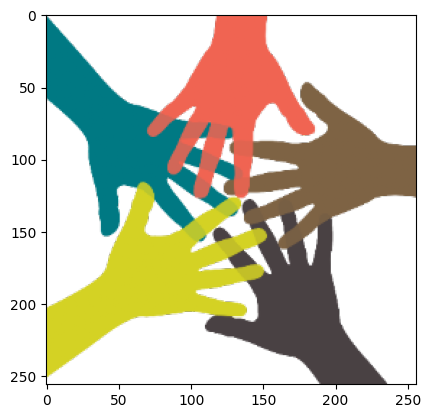

In [95]:
img_rgb = plt.imread('data/smallhands.png', 'PNG')
plt.imshow(img_rgb)

In [96]:
img_rgb.shape

(256, 256, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


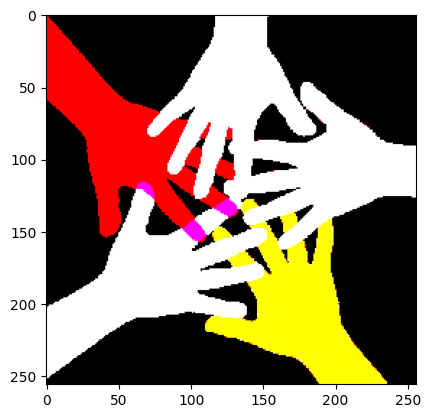

In [97]:
img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
plt.imshow(img_luv)

In [98]:
img_luv.shape

(256, 256, 3)

In [99]:
gap = 2
img_luv = np.asarray([[list(img_luv[i, j, :]) for j in range(0,img_luv.shape[1], gap)]
    for i in np.arange(0,img_luv.shape[0], gap)])

In [100]:
img_luv.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


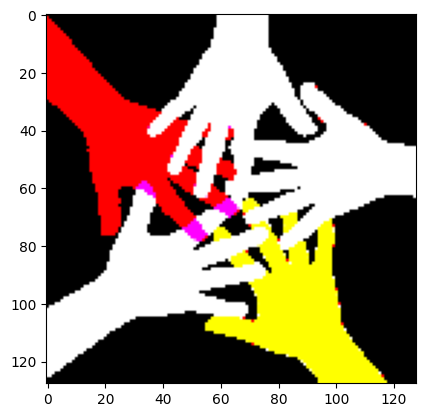

In [101]:
plt.imshow(img_luv)

In [102]:
l, u, v = [], [], []
for i in range(img_luv.shape[0]):
    for j in range(img_luv.shape[1]):
        l.append(img_luv[i, j, 0])
        u.append(img_luv[i, j, 1])
        v.append(img_luv[i, j, 2])

In [103]:
x = np.vstack((l, u, v)).T
x.shape

(16384, 3)

In [104]:
print(x)

[[ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 ...
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]]


# Parallelizing density approximation:

In [105]:
def parallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))

In [106]:
kde = KernelDensity(bandwidth=2.0, atol=0.0005, rtol=0.01).fit(x) 
log_prob = parallel_score_samples(kde, x)

In [107]:
prob = np.exp(log_prob)

# Calculating Vietoris-Rips complex sigma:

In [108]:
sparse = 3
sparse_matrix = np.asarray([[(j%sparse==0)&(i%sparse==0) for i in range(img_luv.shape[1])] for j in range(img_luv.shape[0])])
sparse_array = sparse_matrix.flatten()

In [109]:
x_train = x[sparse_array]
x_train = np.asarray([list(x_train[random.randrange(x_train.shape[0])]) for i in np.arange(20000)])
x_train.shape

(20000, 3)

In [110]:
linked = hierarchy.linkage(x_train, 'single')

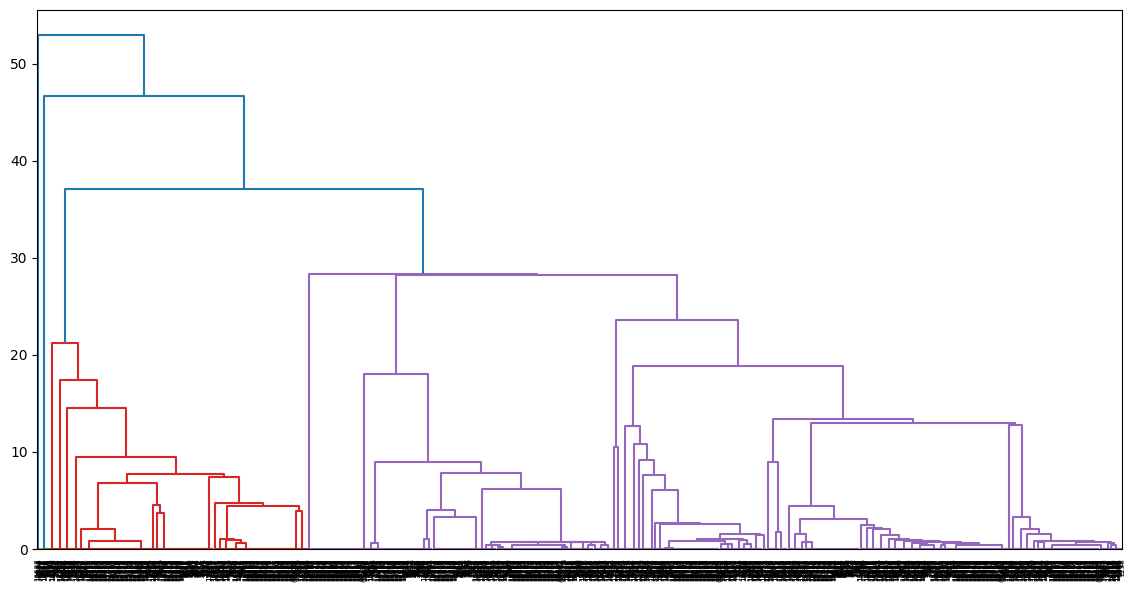

In [112]:
plt.figure(figsize=(14, 7))
hierarchy.dendrogram(linked, p=100, truncate_mode='level')
plt.show()

In [113]:
kdt = KDTree(x, metric='euclidean')

In [114]:
sigmas = np.linspace(0, 50, 20)
avg_neighbor_count = [np.mean([kdt.query_radius([x_train[i]], sigmas[j], return_distance=False)[0].shape[0] for i in range(x_train.shape[0])]) 
           for j in range(len(sigmas))]

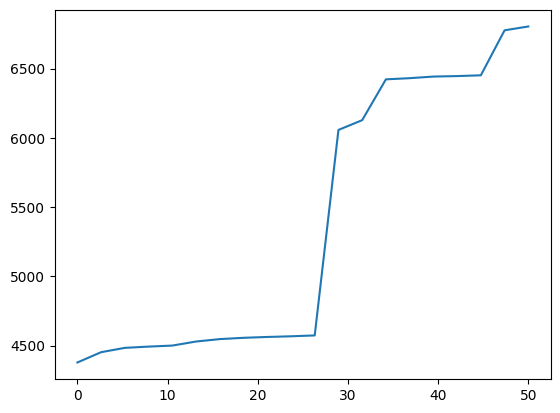

In [115]:
plt.plot(sigmas, avg_neighbor_count)

In [163]:
sigma = 20

# Reducing the number of used points:

In [164]:
group_matrix = np.asarray([[i+j*img_luv.shape[0] for i in np.arange(0, img_luv.shape[1], sparse) for _ in range(sparse)] 
                         for j in np.arange(0, img_luv.shape[0], sparse) for _ in range(sparse)]).flatten()

In [165]:
marked = np.asarray([-1 if sparse_array[i] else group_matrix[i] for i in range(x.shape[0])])
m = 20
for ind in range(x.shape[0]):
    if (marked[ind] == -1):
        nei_drop = kdt.query_radius([x[ind]], sigma/m, return_distance=False)[0]
        nei_drop = np.delete(nei_drop, np.where(nei_drop == ind))
        nei_drop = [elem for elem in nei_drop if marked[elem]!=-1]
        marked[nei_drop] = ind

In [166]:
print(marked[0] == -1)

True


In [167]:
np.sum(marked==-1)

1849

# Implementing disjoint-set data structure:

In [168]:
class UnionFind:
    def __init__(self):
        self.num_to_objects = {}
        self.objects_to_num = {}
        self.parent = {}
    
    def insert(self, object):
        obj_num = len(self.objects_to_num)
        self.objects_to_num[object] = obj_num
        self.num_to_objects[obj_num] = object
        self.parent[obj_num] = obj_num
    
    def find(self, object): 
        if not object in self.objects_to_num:
            self.insert(object)
            return object
        
        stk = [self.objects_to_num[object]]
        par = self.parent[stk[-1]]

        while par != stk[-1]:
            stk.append(par)
            par = self.parent[par]

        for i in stk: self.parent[i] = par
            
        return self.num_to_objects[par]
        
    def union(self, object1, object2): 
        first = self.find(object1)
        second = self.find(object2)
        if first != second:
            first_num = self.objects_to_num[first]
            second_num = self.objects_to_num[second]
            self.parent[second_num] = first_num

# Main clustering function:

In [169]:
def cluster(prob, sigma, tau, x):
    sorted_indices = np.argsort(prob)
    U = UnionFind()
    n = len(prob)
    births = {}
    deaths = {}
    
    for i in reversed(range(n)):
        id = sorted_indices[i]
        if (marked[id]==-1):
            neighbors = kdt.query_radius([x[id]], sigma, return_distance=False)[0]
            S = [elem for elem in neighbors if (elem in sorted_indices[(i+1):] and (marked[elem]==-1))]
            if not S:
                U.insert(id)
                births[id] = -prob[id]
            else:
                parent = S[np.asarray([prob[j] for j in S]).argmax()]
                U.union(parent, id)
                # spajanje
                ei = U.find(id)
                roots = [U.find(ele) for ele in S]
                for ej in roots:
                    if ei != ej and prob[U.find(ej)] - prob[id] < tau:
                        U.union(ei, ej)
                        deaths[ej] = -prob[id]
                e_ = -1
                for ej in roots:
                    if e_ == -1 or prob[U.find(ej)] > prob[U.find(e_)]:
                        e_ = ej
                if ei != e_ and prob[U.find(ei)] - prob[id] < tau:
                    U.union(e_, ei)
                    deaths[ei] = -prob[id]

    for i in births.keys():
        if i not in deaths.keys():
            deaths[i] = np.inf
        
    return U, births, deaths

In [170]:
U, births, deaths = cluster(prob, sigma, np.inf, x)

# Plotting persistence diagram:

In [171]:
lifecycle = [(births[idx], deaths[idx]) for idx in births.keys()]

In [172]:
res = [(0, elem) for elem in lifecycle]

In [173]:
persistence = [elem[1]-elem[0] for elem in lifecycle]
_ = sorted([elem for elem in persistence if ~np.isinf(elem)], reverse=True)

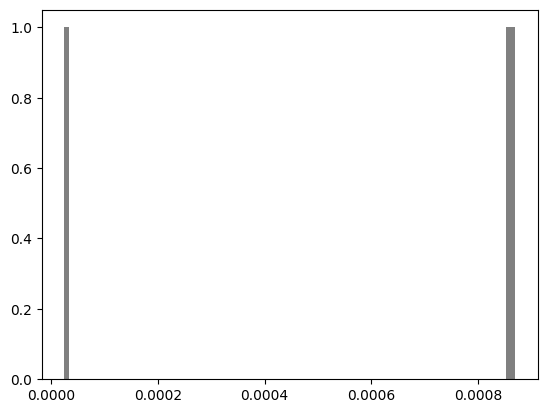

In [174]:
plt.hist([elem for elem in persistence if ~np.isinf(elem)], bins=100, color = 'gray')
plt.show()

<Figure size 1800x400 with 0 Axes>

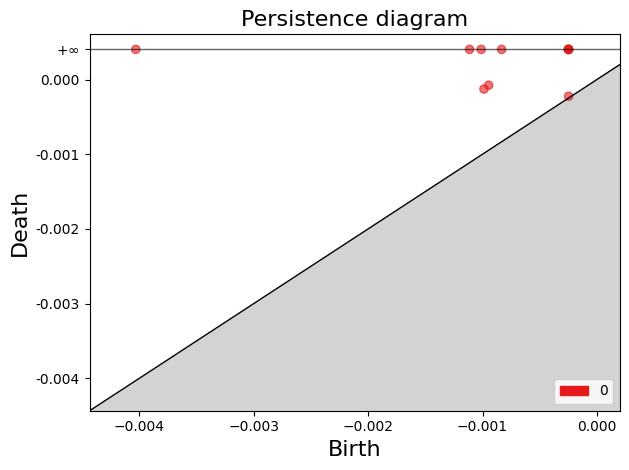

In [175]:
import matplotlib

plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gd.plot_persistence_diagram(res)
plt.tight_layout()
plt.show()

<Figure size 1800x400 with 0 Axes>

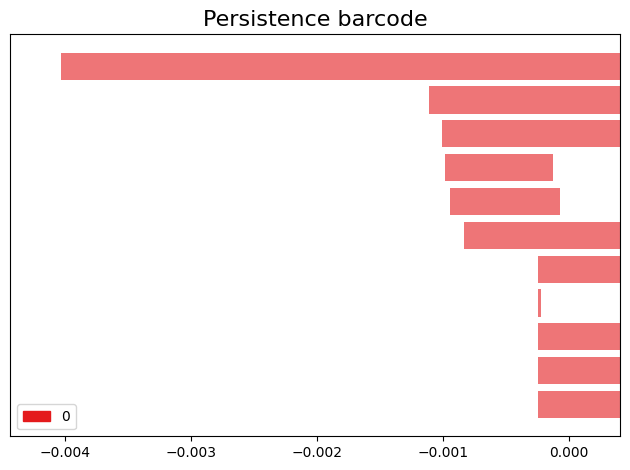

In [176]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gd.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

Function to graph x = y:

In [177]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

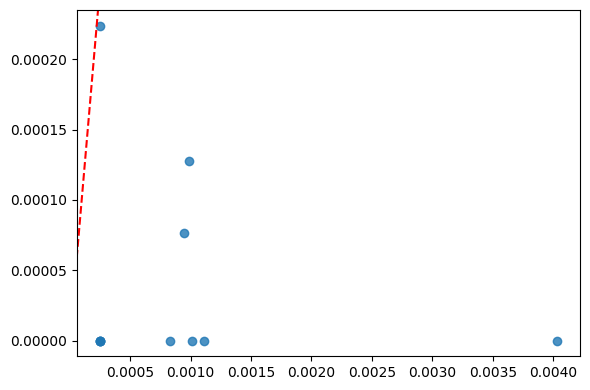

In [178]:
lifecycle_mod = [(-elem[0], 0) if elem[1]==np.inf else (-elem[0], -elem[1]) for elem in lifecycle]
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter([elem[0] for elem in lifecycle_mod], [elem[1] for elem in lifecycle_mod], alpha=0.8)
add_identity(ax, color='red', ls='--')
plt.tight_layout()
plt.show()

In [179]:
U, births, deaths = cluster(prob, sigma=sigma, tau=0.0002, x=x)

In [180]:
len(np.unique(list(U.parent.values())))

10

In [181]:
np.unique(list(U.parent.values()))

array([   0,  889,  896,  897, 1253, 1431, 1778, 1799, 1814, 1819])

# Centroid calculation:

In [182]:
cen, sts = [], []
ind = np.asarray(list(U.num_to_objects.values()))
rts = np.asarray(list(U.parent.values()))

In [183]:
for ele in np.unique(rts):
    cen.append(U.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [184]:
cen = np.asarray(cen)

In [187]:
threshold = 20
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

Broj klastera vecih od  20  je  6


Function to generate random colorings for future clusters:

In [188]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i+123)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0,0,0])
    return colors
colors = cluster_color(cen)

# Grouping points belonging to same clusters:

In [189]:
idxs = []
for idx, grp in enumerate(sts):
    idxs = idxs + list(np.repeat(idx, len(sts[idx])))

In [190]:
grps = []
for idx, grp in enumerate(sts):
    grps = grps + list(grp)

In [191]:
cluster_dict = {k: v for k,v in zip(grps, idxs)}

In [192]:
#for i in range(len(marked)):
#    if marked[i] != -1:
#        while marked[marked[i]] != -1:
#            marked[i] = marked[marked[i]]
idxs_all = idxs + [cluster_dict[elem] for idx,elem in enumerate(marked) if elem!=-1]
len(idxs_all)

16384

In [193]:
d = [elem for idx, elem in enumerate(marked) if elem!=-1]
k = [elem for elem in d if elem == 981]
k

[]

In [194]:
len(idxs)

1849

In [195]:
grps_all = grps + [idx for idx,elem in enumerate(marked) if elem!=-1]
len(grps_all)

16384

In [196]:
cluster_sort = sorted(zip(grps_all, idxs_all))
img_clustered = [[colors[elem[1]]] for elem in cluster_sort]
len(img_clustered)

16384

In [197]:
img_clustered_all = np.reshape(np.asarray(img_clustered), img_luv.shape)
img_clustered_all.shape

(128, 128, 3)

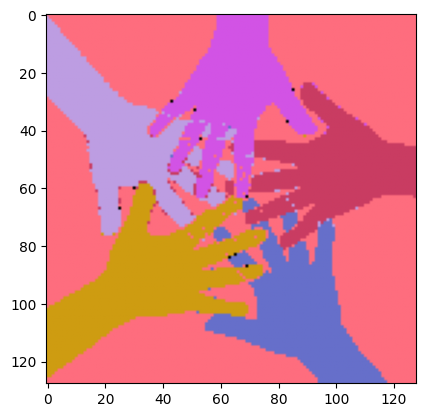

In [198]:
plt.imshow(img_clustered_all)

In [56]:
cluster_sort[0][0]

0

In [57]:
marked[978]

-1

In [58]:
cluster_dict[831]

0